# RASR
from Curlander
\begin{equation}
    \text{RASR}_i = \dfrac{\[ \sum_{j=-n_h;\  j \neq 0}^{n_h} \dfrac{\sigma_{ij} \[ \int_{-B_D/2}^{B_D/2}{\left| G\left(\eta_{ij}, f_D\right)\right|^2 \ df_D}{}\]}{R_{ij}^3 \sin{\eta}_{ij}}\]}
                        {\[ \dfrac{\sigma_{i} \[ \int_{-B_D/2}^{B_D/2}{\left| G\left(\eta_{i}, f_D\right)\right|^2 \ df_D}{}\]}{R_{i}^3 \sin{\eta}_{i}}\]}
\end{equation}

with
\begin{equation}
    R_{ij} = c(t_i + j\ \text{PRI}) /2
\end{equation}

\begin{equation}
    \eta_{ij} = \arccos\left( - \dfrac{R_E^2 +R_{ij}^2 - (R_E + h)^2}{2 R_E R_{ij}}\right)
\end{equation}
the problem is symmetric, every range has two gain contributions in the two pattern hemispheres
also $\sigma$ is assumed 1 for simplicity

In [1]:
import numpy as np
from numpy import sin, cos, arcsin, arccos
from design_functions import *
from ambiguity_functions import *
from spherical_earth_geometry_radar import *
from radartools.farField import UniformAperture
from scipy import integrate

# test parameters
PRF = 4000
PRI = 1 / PRF

# doppler bandwidth
Bd = 7000

wa = 0.3
la = 2
h = 500e3
freq = 10e9
c = 299792458
lambda_c = c / freq

incidence_angle =  31.8
looking_angle = incidence_angle_to_looking_angle(incidence_angle * np.pi / 180, h)

radGeo = RadarGeometry()
radGeo.set_initial_position(0, 0, h)
radGeo.set_rotation(looking_angle, 0, 0)
v_s = radGeo.orbital_speed()
radGeo.set_speed(v_s)

uniap = UniformAperture(la, wa, freq)

In [2]:
# step 1 find orders
r0, rg = range_from_theta(incidence_angle, h)
order = int(r0 * 2 / (c * PRI))
print(order)
# horizon
r_hor, rghor = range_from_theta(90, h)
nH = int(r_hor * 2 / (c * PRI)) - order
print(nH)
nN = order - int(h * 2 / (c * PRI))
print(nN)

15
53
2


In [3]:
r0

580299.178281352

In [4]:
# Step 2 Denominator

In [5]:
# Range Axis
rax = np.linspace(order * c * PRI / 2, (order + 1) * c * PRI / 2, 200)
rax
# Incidence angle Axis
rgax, theta = range_slant_to_ground(rax, h)
# Doppler Axis
dax = np.linspace(-Bd / 2, Bd / 2, 111)
#theta * 180 / np.pi

In [6]:
# gain
D, I = np.meshgrid(dax, theta)
G, maxg = gain_from_doppler(D, I, radGeo, uniap, lambda_c, v_s, h)
G /= maxg
# square and integrate over doppler
Gint = integrate.simps(G ** 2, D, axis=1)
#print(Gint)
Denom = Gint / (rax ** 3 * sin(theta))

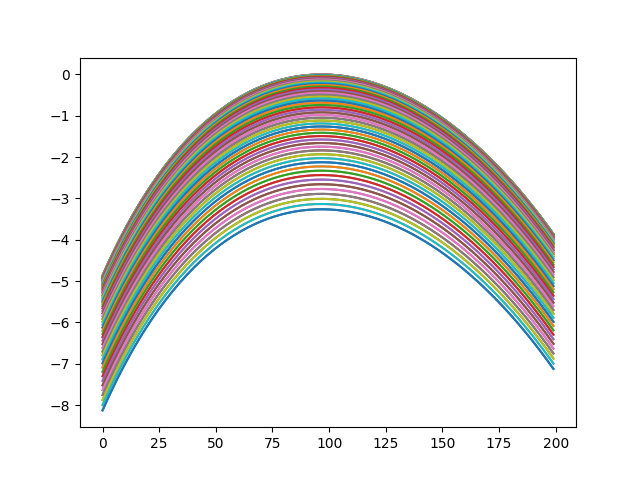

In [7]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Qt5Agg')
%matplotlib widget

fig, ax = plt.subplots(1)
ax.plot(10 * np.log10(G))
plt.show()

In [8]:
# Step 3 Numerator
# for every possible replica
import time
j = np.arange(-nN, nH)
Numer = np.zeros_like(Denom)
raxjj = np.zeros_like(Numer).astype('float64')
for jj in tqdm(j):
    # 1 range axis
    raxjj = float(jj) * c * PRI / 2 + rax
    raxj = np.where(raxjj <= h, h, raxjj)
    #np.set_printoptions(precision=13)
    # doppler axis is still the same
    # 2 incidence angle axis
    rgax, thetaj = range_slant_to_ground(raxj, h)
    D, Ij = np.meshgrid(dax, thetaj)
    #print(jj, ': ', sin(thetaj))
    # 3 returns from after nadir (in the looking direction of the radar)
    if jj != 0:  # j = 0 is the signal, not the ambiguity
        G, maxg = gain_from_doppler(D, Ij, radGeo, uniap, lambda_c, v_s, h)
        G /= maxg
        Gint = integrate.simps(G ** 2, D, axis=1)
        Gint = np.where(raxjj <= h, 0, Gint)
        Numer += np.where(sin(thetaj) != 0, Gint / (raxj ** 3 * sin(thetaj)), 0)
        #ax.plot(10 * np.log10(Gint))
    # 4 returns from behind the nadir (in the other direction)
    G, maxg = gain_from_doppler(dax, -Ij, radGeo, uniap, lambda_c, v_s, h)
    G /= maxg
    Gint = integrate.simps(G ** 2, D, axis=1)
    Gint = np.where(raxjj <= h, 0, Gint)
    #ax.plot(10 * np.log10(Gint))
    Numer += np.where(sin(thetaj) != 0, Gint / (raxj ** 3 * sin(thetaj)), 0)
   
    #time.sleep(0.1)
    #fig.canvas.draw()
    #fig.canvas.flush_events()


  0%|          | 0/55 [00:00<?, ?it/s]C:\Users\smen851\PycharmProjects\design-baseline\spherical_earth_geometry_radar.py:350: RuntimeWarning: invalid value encountered in arccos
  theta_e = np.arccos(cos_theta_e) * np.sign(incidence_mesh) # to consider also incidence angles behind nadir
C:\Users\smen851\AppData\Local\Temp\ipykernel_20428\348167392.py:23: RuntimeWarning: invalid value encountered in divide
  Numer += np.where(sin(thetaj) != 0, Gint / (raxj ** 3 * sin(thetaj)), 0)
C:\Users\smen851\AppData\Local\Temp\ipykernel_20428\348167392.py:31: RuntimeWarning: invalid value encountered in divide
  Numer += np.where(sin(thetaj) != 0, Gint / (raxj ** 3 * sin(thetaj)), 0)
100%|██████████| 55/55 [00:04<00:00, 13.07it/s]


In [9]:
raxjj = rax + 8 * c * PRI / 2
raxjj / 1000
raxj = np.where(raxjj <= h, h, raxjj)
raxj

array([861903.31675   , 862091.62859548, 862279.94044095, 862468.25228643,
       862656.56413191, 862844.87597739, 863033.18782286, 863221.49966834,
       863409.81151382, 863598.1233593 , 863786.43520477, 863974.74705025,
       864163.05889573, 864351.37074121, 864539.68258668, 864727.99443216,
       864916.30627764, 865104.61812312, 865292.92996859, 865481.24181407,
       865669.55365955, 865857.86550503, 866046.1773505 , 866234.48919598,
       866422.80104146, 866611.11288693, 866799.42473241, 866987.73657789,
       867176.04842337, 867364.36026884, 867552.67211432, 867740.9839598 ,
       867929.29580528, 868117.60765075, 868305.91949623, 868494.23134171,
       868682.54318719, 868870.85503266, 869059.16687814, 869247.47872362,
       869435.7905691 , 869624.10241457, 869812.41426005, 870000.72610553,
       870189.03795101, 870377.34979648, 870565.66164196, 870753.97348744,
       870942.28533291, 871130.59717839, 871318.90902387, 871507.22086935,
       871695.53271482, 8

In [10]:
# Incidence angle Axis

RASR = Numer / Denom

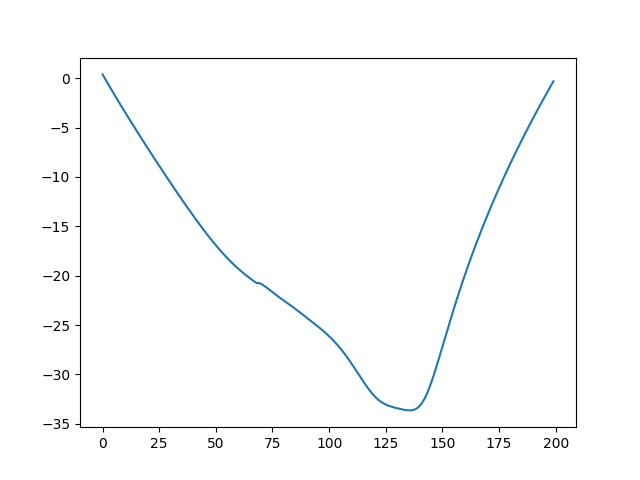

In [11]:
fig, ax = plt.subplots(1)
ax.plot(10 * np.log10(RASR))

In [12]:
from ambiguity_functions import RASR
rgax, theta = range_slant_to_ground(rax, h)
Rasr = RASR(radGeo, uniap, theta, PRI, Bd, lambda_c, v_s, h)


  0%|          | 0/55 [00:00<?, ?it/s]C:\Users\smen851\PycharmProjects\design-baseline\ambiguity_functions.py:172: RuntimeWarning: invalid value encountered in divide
  Numer += np.where(sin(thetaj) != 0, Gint / (raxj ** 3 * sin(thetaj)), 0)
C:\Users\smen851\PycharmProjects\design-baseline\ambiguity_functions.py:178: RuntimeWarning: invalid value encountered in divide
  Numer += np.where(sin(thetaj) != 0, Gint / (raxj ** 3 * sin(thetaj)), 0)
100%|██████████| 55/55 [00:04<00:00, 12.70it/s]


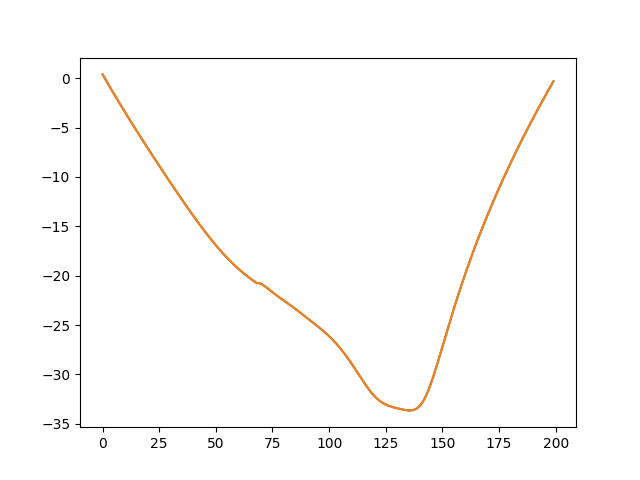

In [13]:
ax.plot(10 * np.log10(Rasr))
plt.show()